# Sport Medicine: Deep Learning in Medical Imaging


## Implementing AlexNet


### Required packages:

[1] [pytorch](https://pytorch.org/docs/stable/index.html) is an open source machine learning framework.

[2] [TorchVision](https://pytorch.org/vision/stable/index.html)  package consists of popular datasets, model architectures, and common image transformations for computer vision.

[3] [matplotlib](http://matplotlib.org) is a comprehensive library for creating static, animated, and interactive visualizations in Python

[4] [random] (https://docs.python.org/3/library/random.html) generate pseudo-random numbers

[5] [os] (https://docs.python.org/3/library/os.html) module provides a portable way of using operating system dependent functionality.

**Reference:** https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:800px;height:200px;">
<caption><center> <u>Figure</u>: LeNet and AlexNet for image classification (source: wiki).</center></caption>


In [1]:
import torch
import torchvision 
import random
import os
from torch import nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader
from pathlib import Path
import torch.optim as optim
import torch.nn.functional as F 

### Hyper-parameters to tune in due course:

[batch_size] = The batch size is a number of samples processed before the model is updated

[epochs] = The number of epochs defines the number times that the learning algorithm will work through the entire training dataset

In [2]:
batch_size = 16 # create batch-based on how much memory you have and your data size
epochs = 25

### Data loading and pre-processing
**Steps**

[1] Load data - use generic data loader from torchvision ([torch vision available](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html))

[2] Transform --> We convert data to ToTensor, and resize it to 227 x 227 (following AlexNet paper)


In [3]:
# Paths to data:
train_dir = Path('/kaggle/input/knee-osteoarthritis-dataset-with-severity/train')
val_dir = Path('/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/')
test_dir = Path('/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/')

# Preparing transform for step [2]

transform = transforms.Compose([
    transforms.Resize(227),   # Note: here you will resize image to 227 that is input to the AlexNet
    transforms.ToTensor()
    ])

# A generic data loader and apply transform:

train_set = torchvision.datasets.ImageFolder(train_dir, transform=transform)
valid_set= torchvision.datasets.ImageFolder(val_dir, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_dir, transform=transform)


### Make [DataLoaders](https://pytorch.org/docs/stable/data.html): DataLoader wraps an iterable around the Dataset to enable easy access to the samples


In [4]:
# Now we need to create dataLoaders that will allow to iterate during training

traindataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valdataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
testdataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Number of train samples: ", len(train_set))
print("Number of  val  samples: ", len(valid_set))
print("Number of test  samples: ", len(test_set))

Number of train samples:  5778
Number of  val  samples:  826
Number of test  samples:  1656


### Identify labels in our data set. In our dataset, the names and the number of classes can be identified by looking into subfolders of our data


In [5]:
def get_class_names(folder_path):
    class_names = []
    subfolders = [f.name for f in os.scandir(folder_path) if f.is_dir()]
    class_names = sorted(subfolders)
    return class_names

In [6]:
folder_path = train_dir
class_names = get_class_names(folder_path)
print(f"Number of classes: {len(class_names)}")
print(class_names)

Number of classes: 5
['0', '1', '2', '3', '4']


### Look into data! Always!

In [7]:
def plot_images_of_each_class(directory, no_classes):
    for i in range(no_classes):
        class_dir_path = os.path.join(directory, str(i))

        # selecting a random image from the selected class
        image_file = random.choice(os.listdir(class_dir_path))
        image_path = os.path.join(class_dir_path, image_file)

        # Loading and display the image in a subplot
        plt.subplot(1, no_classes, i + 1)  
        image = Image.open(image_path)
        plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        plt.title(f"Class: {i}")
        plt.axis('off')

    plt.show()

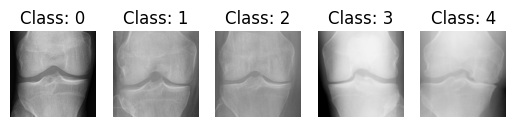

In [8]:
plot_images_of_each_class(train_dir, len(class_names))

### Create your AlexNet model
- Please note that your input image size will make difference on your hard-coded feature sizes in final layers (fully connected layers)
- Always be aware of what size input is used, here for convenience we will follow the original paper and reshape image to 224x224 
- our problem (data set) has only 5 classes - change last layer from 1000 to 5

<img src="https://raw.githubusercontent.com/sharibox/HDS-CDT2020/main/images/AlexNet.png" style="width:800px;height:200px;">
<caption><center> <u>Figure</u>: AlexNet for image classification.</center></caption>

In [9]:
# create your model 
class AlexNet(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        ## define the layers: you can write this all as nn.Sequence to call in one line
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(6*6*256, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_labels),
        )

    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [10]:
# call your model:

my_first_model = AlexNet(len(train_set.classes))

### Prepare an optimizer, set learning rate, and you loss function
- Here you will use model.train and use gradients
- Also, you will use criterion to compute loss 
- Compute metric to know how well it is performing
- save them to display mean for each epoch

In [11]:
# let's first check what compute we have available:

if torch.cuda.is_available():
    print('cuda is available')
else: print('mere cpu')
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda is available


### Choose optimiser:
(https://pytorch.org/docs/stable/optim.html)
here we are going the most popular one: Adam (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

### Choose loss function: (what problem are we solving?)
classification: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [12]:
optimiser = optim.Adam(my_first_model.parameters(),lr=0.0001)
    
criterion = nn.CrossEntropyLoss()

my_first_model = my_first_model.to(device)

### Prepare accuracy measure to know how your training is going 

[1] Accuracy in classification is important and you want higher accuracy

In [13]:
# define accuracy
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### Getting into training model

[1] Loss function is important to keep track (mostly you minimise it, i.e. it should go down)

In [ ]:
# 4] Run your training loop with optimiser trying to minimise your cost/loss, dont forget to backpropagate your loss
my_first_model.to(device)
my_first_model.train()


log_interval = 100 # for visualising your iterations 

# main loop
for epoch in range(epochs):
    train_loss, valid_loss, train_top1,val_top1  = [], [], [], []
  
    
    for batch_idx, (data, label) in enumerate(traindataloader):

        optimiser.zero_grad()
        out = my_first_model(data.to(device))
        loss = criterion(out, label.to(device))
        loss.backward()
        optimiser.step()
        
        train_loss.append(loss.item())
        acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
        train_top1.append(acc_1[0].item())
        
        if (batch_idx % log_interval) == 0:
            print('Train Epoch is: {}, train loss is: {:.2f}, train accuracy top1% is {:.2f}%'.format(epoch, np.mean(train_loss),
                                                                                           np.mean(train_top1)))
            
            with torch.no_grad():
                for i, (data, label) in enumerate(valdataloader):
                    data, label = data.to(device), label.to(device)
                    out = my_first_model(data)
                    loss = criterion(out, label.to(device))
                    acc_1 = topk_accuracy(out, label.to(device),topk=(1,))

                    valid_loss.append(loss.item())
                    acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
                    val_top1.append(acc_1[0].item())
    
            print('Val Epoch is: {}, val loss is: {:.2f}, val accuracy top1% is {:.2f}%'.format(epoch, np.mean(valid_loss),
                                                                                           np.mean(val_top1)))
    
        
        


Train Epoch is: 0, train loss is: 1.61, train accuracy top1% is 31.25%
Val Epoch is: 0, val loss is: 1.60, val accuracy top1% is 25.75%


### Let's assume our model is trained. Let's see how it performs on unseen data (test data)

In [ ]:
# Compute total test accuracy
total = 0
my_first_model.eval()
with torch.no_grad():
    for data in testdataloader:
        image, labels = data
        output = my_first_model(image.to(device))
        _, preds_tensor = torch.max(output, 1)
        acc_1_test = topk_accuracy(output, labels.to(device),topk=(1,) )
        total +=np.mean(acc_1_test[0].detach().cpu().numpy())
print('test accuracy is {:.2f}% on test dataset'.format(total/len(testdataloader)))

# Alternatively you can compute for each class seperately as well 
(taken from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in testdataloader:
        images, labels = data
        outputs = my_first_model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.to(device) == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:2s} is: {:.2f} %".format(classname,
                                                   accuracy))